In [1]:
PIANO_GENERATOR_MODEL_PATH = 'piano_model'
PIANO_GENERATOR_MODEL_WEIGHTS_PATH = './piano models/piano_model_vae_weights'

In [2]:
import os

import glob
import pickle
import numpy
import pandas
import numpy as np
import matplotlib.pyplot as plt
from itertools import chain
from pydub import AudioSegment
from collections import Counter
from music21 import converter, instrument, note, chord, stream
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras.layers import Activation
from keras.layers import BatchNormalization as BatchNorm
from keras.utils import np_utils
from keras.callbacks import ModelCheckpoint

from tensorflow import keras
from keras import layers

In [3]:
def get_notes(path):
    """ Get all the notes and chords from the midi files in the 'path' directory """
    notes = []

    print(len(glob.glob(path + '/*.mid')))
    for file in glob.glob(path + '/*.mid'):
        midi = converter.parse(file)

#         print('parsing %s' % file)

        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [4]:
def get_notes(path):
    """ Get all the notes and chords from the midi files in the 'path' directory """
    notes = []

    print(len(glob.glob(path + '/*.mid')))
    for file in glob.glob(path + '/*.mid'):
        midi = converter.parse(file)


        notes_to_parse = None

        try: # file has instrument parts
            s2 = instrument.partitionByInstrument(midi)
            notes_to_parse = s2.parts[0].recurse() 
        except: # file has notes in a flat structure
            notes_to_parse = midi.flat.notes

        for element in notes_to_parse:
            if isinstance(element, note.Note):
                notes.append(str(element.pitch))
            elif isinstance(element, chord.Chord):
                notes.append('.'.join(str(n) for n in element.normalOrder))

    with open('data/notes', 'wb') as filepath:
        pickle.dump(notes, filepath)

    return notes

In [5]:
def all_idx(idx, axis):
    grid = np.ogrid[tuple(map(slice, idx.shape))]
    grid.insert(axis, idx)
    return tuple(grid)

In [6]:
def onehot_initialization(a, ncols):
    out = np.zeros(a.shape + (ncols,), dtype=int)
    out[all_idx(a, axis=2)] = 1
    return out

In [7]:
def prepare_sequences(notes, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    sequence_length = 32

    # get all pitch names
    pitchnames = sorted(set(item for item in notes))

     # create a dictionary to map pitches to integers
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    network_input = []
    
    # create input sequences and the corresponding outputs
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    ncols = max(max(network_input))+1
    ncols = ncols + (ncols%4)
    network_input = onehot_initialization(np.array(network_input), ncols)
    return network_input

In [8]:
notes = get_notes('midi_songs')

93


In [9]:
n_vocab = len(set(list(chain.from_iterable(notes))))
network_input = prepare_sequences(notes, n_vocab)

In [184]:
network_input.shape

(1868, 32, 256)

In [185]:
254%4

2

## Model - Variational Autoencoder

### Sampling layer

In [10]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

### Encoder

In [11]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(32, 256, 1))
x = layers.Conv2D(32, 3, activation="relu", strides=2, padding="same")(encoder_inputs)
x = layers.Conv2D(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Flatten()(x)
x = layers.Dense(16, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 32, 256, 1)] 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 16, 128, 32)  320         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 8, 64, 64)    18496       conv2d[0][0]                     
__________________________________________________________________________________________________
flatten (Flatten)               (None, 32768)        0           conv2d_1[0][0]                   
____________________________________________________________________________________________

### Decoder

In [12]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(8 * 64 * 64, activation="relu")(latent_inputs)
x = layers.Reshape((8, 64, 64))(x)
x = layers.Conv2DTranspose(64, 3, activation="relu", strides=2, padding="same")(x)
x = layers.Conv2DTranspose(32, 3, activation="relu", strides=2, padding="same")(x)
decoder_outputs = layers.Conv2DTranspose(1, 3, activation="sigmoid", padding="same")(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_1 (Dense)              (None, 32768)             98304     
_________________________________________________________________
reshape (Reshape)            (None, 8, 64, 64)         0         
_________________________________________________________________
conv2d_transpose (Conv2DTran (None, 16, 128, 64)       36928     
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 32, 256, 32)       18464     
_________________________________________________________________
conv2d_transpose_2 (Conv2DTr (None, 32, 256, 1)        289       
Total params: 153,985
Trainable params: 153,985
Non-trainable params: 0
_____________________________________________________

### VAE Model

In [13]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
        self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(
                        data,
                        reconstruction
                    ), axis=(1, 2)
                )
            )
            kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
            kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
        self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
            "kl_loss": self.kl_loss_tracker.result(),
        }

In [226]:
network_input.shape

(1868, 32, 256)

In [227]:
np.expand_dims(network_input, -1).astype("float32").shape

(1868, 32, 256, 1)

In [228]:
vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(np.expand_dims(network_input, -1).astype("float32"), epochs=20, batch_size=32)

Epoch 1/20
59/59 [==============================] - 11s 175ms/step - loss: 3233.9015 - reconstruction_loss: 1476.2596 - kl_loss: 66.1833
Epoch 2/20
59/59 [==============================] - 10s 171ms/step - loss: 226.9922 - reconstruction_loss: 218.3707 - kl_loss: 0.7390
Epoch 3/20
59/59 [==============================] - 10s 171ms/step - loss: 207.1180 - reconstruction_loss: 205.2762 - kl_loss: 0.3143
Epoch 4/20
59/59 [==============================] - 10s 170ms/step - loss: 201.9208 - reconstruction_loss: 201.1267 - kl_loss: 0.1213
Epoch 5/20
59/59 [==============================] - 10s 176ms/step - loss: 199.2603 - reconstruction_loss: 198.6637 - kl_loss: 0.1221
Epoch 6/20
59/59 [==============================] - 10s 177ms/step - loss: 196.6725 - reconstruction_loss: 196.0060 - kl_loss: 0.1404
Epoch 7/20
59/59 [==============================] - 11s 186ms/step - loss: 194.2262 - reconstruction_loss: 193.9510 - kl_loss: 0.1674
Epoch 8/20
59/59 [==============================] - 11s 192

In [248]:
#01: 30 epochs
#02: 20 epochs
vae.save_weights(PIANO_GENERATOR_MODEL_WEIGHTS_PATH + '_02')

### Load pretrained model

In [32]:
vae1 = VAE(encoder, decoder)

In [33]:
vae1.load_weights(PIANO_GENERATOR_MODEL_WEIGHTS_PATH + '_01')

### Generate piano rolls with vae model

In [14]:
def create_midi(prediction_output, 
                output_path):
    """ convert the output from the prediction to notes and create a midi file
        from the notes """
    offset = 0
    output_notes = []

    # create note and chord objects based on the values generated by the model
    for pattern in prediction_output:
        # pattern is a chord
        if ('.' in pattern) or pattern.isdigit():
            notes_in_chord = pattern.split('.')
            notes = []
            for current_note in notes_in_chord:
                new_note = note.Note(int(current_note))
                new_note.storedInstrument = instrument.Piano()
                notes.append(new_note)
            new_chord = chord.Chord(notes)
            new_chord.offset = offset
            output_notes.append(new_chord)
        # pattern is a note
        else:
            new_note = note.Note(pattern)
            new_note.offset = offset
            new_note.storedInstrument = instrument.Piano()
            output_notes.append(new_note)

        # increase offset each iteration so that notes do not stack
#         offset += 0.5
        offset += 1

    midi_stream = stream.Stream(output_notes)

    midi_stream.write('midi', fp=output_path)

In [15]:
def prepare_sequences(notes, pitchnames, n_vocab):
    """ Prepare the sequences used by the Neural Network """
    # map between notes and integers and back
    note_to_int = dict((note, number) for number, note in enumerate(pitchnames))

    sequence_length = 32
    network_input = []
    
    for i in range(0, len(notes) - sequence_length, 1):
        sequence_in = notes[i:i + sequence_length]
        network_input.append([note_to_int[char] for char in sequence_in])

    ncols = max(max(network_input))+1
    ncols = ncols + (ncols%4)
    network_input = onehot_initialization(np.array(network_input), ncols)

    return network_input

In [16]:
def generate(model, output_path):
    """ Generate a piano midi file """
    #load the notes used to train the model
    with open('data/notes', 'rb') as filepath:
        notes = pickle.load(filepath)

    # Get all pitch names
    pitchnames = sorted(set(item for item in notes))
    # Get all pitch names
    n_vocab = len(set(notes))

    network_input = prepare_sequences(notes, pitchnames, n_vocab)
    int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
    while True:
        inp = np.random.normal(0,1,size=(1, latent_dim))
        item = vae.decoder.predict(inp)[0]
        prediction_output = []
        for i in item:
            predicted_note = i.flatten()
            index = predicted_note.argmax()
            result = int_to_note[index]
            prediction_output.append(result)

        n_unique_notes = len(Counter(prediction_output).keys())
        if n_unique_notes > 8:
            break
    
#     return prediction_output
    create_midi(prediction_output, output_path)

In [247]:
for i in range(5):
    print(generate(vae, 'dsf'))

['D5', 'D5', '6.9.11.2', '6.9.11.2', 'D4', 'D4', '6.9.11.2', 'D4', '11.0.4.7', '2.5.9', '2.5.9', '2.5.9', 'A2', 'A2', 'A2', 'A2', 'D3', 'D3', 'D3', 'D3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', '7.0', '4.5.9.0', '4.5.9.0', '4.5.9.0', '4.5.9.0']
['D5', '6.9.11.2', '6.9.11.2', '6.9.11.2', '6.9.11.2', 'D4', '6.9.11.2', 'D4', '11.0.4.7', '2.5.9', 'B3', 'B3', 'A2', 'A2', 'A2', 'A2', 'D3', 'D3', 'D3', 'D3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', 'B3', '7.0', '7.0', '4.5.9.0', '4.5.9.0', 'D4']
['6.9.11.2', '6.9.11.2', '1.2.4.6.9', '8.11.1.4', '1.2.4.6.9', '1.2.4.6.9', '1.2.4.6.9', 'D3', 'D3', '2.5.9', '7.11', '7.11', '2.5.9', '2.5.9', '2.5.9', '2.5.9', 'D3', '2.5.9', 'A3', '7.10.0.3', '8.11.1.4', 'D3', 'A3', 'A3', 'A3', 'A3', 'A3', 'A3', 'F2', '7.0', '6.10.11.1', 'G3']
['8.11.1.4', '8.11.1.4', '8.11.1.4', '8.11.1.4', '8.11.1.4', '3.7', '3.7', 'D3', '5.9.0', '5.9.0', '5.9.0', '5.9.0', '5.9.0', '5.9.0', '5.9.0', '2.5.9', 'D3', 'D3', 'D3', 'D3', 'D3', '7.10.0.3', 'D3', 'D3', '3.6.8.10.11', '3.6.8

In [362]:
generate(vae, output_path='vae01_piano_13.mid')

In [363]:
_ = os.system('fluidsynth -ni Touhou.sf2 vae01_piano_13.mid -F vae01_piano_13.wav -r 44100')

### Label clusters

In [29]:
def plot_label_clusters(vae, data, labels):
    # display a 2D plot of the digit classes in the latent space
    z_mean, _, _ = vae.encoder.predict(data)
    plt.figure(figsize=(12, 10))
    plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
    plt.colorbar()
    plt.xlabel("z[0]")
    plt.ylabel("z[1]")
    plt.show()


In [18]:
def most_common(lst):
    return max(set(lst), key=lst.count)

In [314]:
pitchnames = sorted(set(item for item in notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
notes_per_pattern = [[int_to_note[note.argmax()] for note in pattern] for pattern in network_input]
most_common_note_per_pattern = list(map(most_common, notes_per_pattern))

In [34]:
le = LabelEncoder()
labels = le.fit_transform(most_common_note_per_pattern)

x_train = np.expand_dims(network_input, -1).astype("float32")

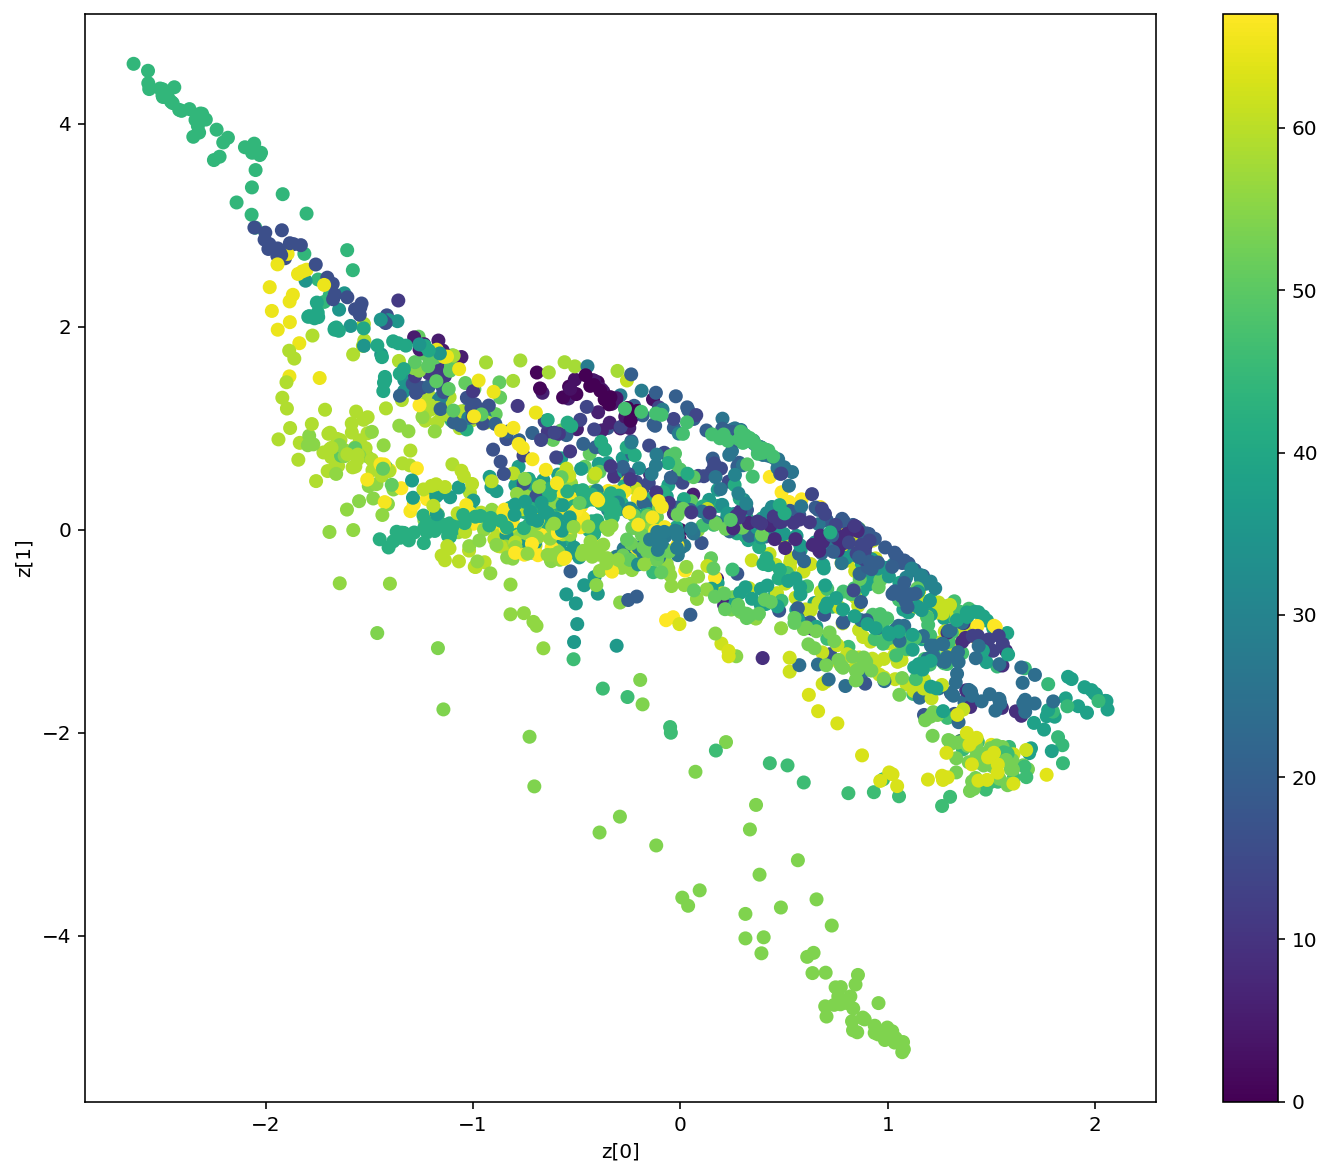

In [317]:
plot_label_clusters(vae, x_train, labels)

In [358]:
most_common_labels = [item[0] for item in Counter(labels).most_common(10)]

In [359]:
label_is_common = [label in most_common_labels for label in labels]

In [360]:
x_train_common_label = x_train[label_is_common]
labels_common_label = labels[label_is_common]
le = LabelEncoder()
labels_common_label = le.fit_transform(labels_common_label)

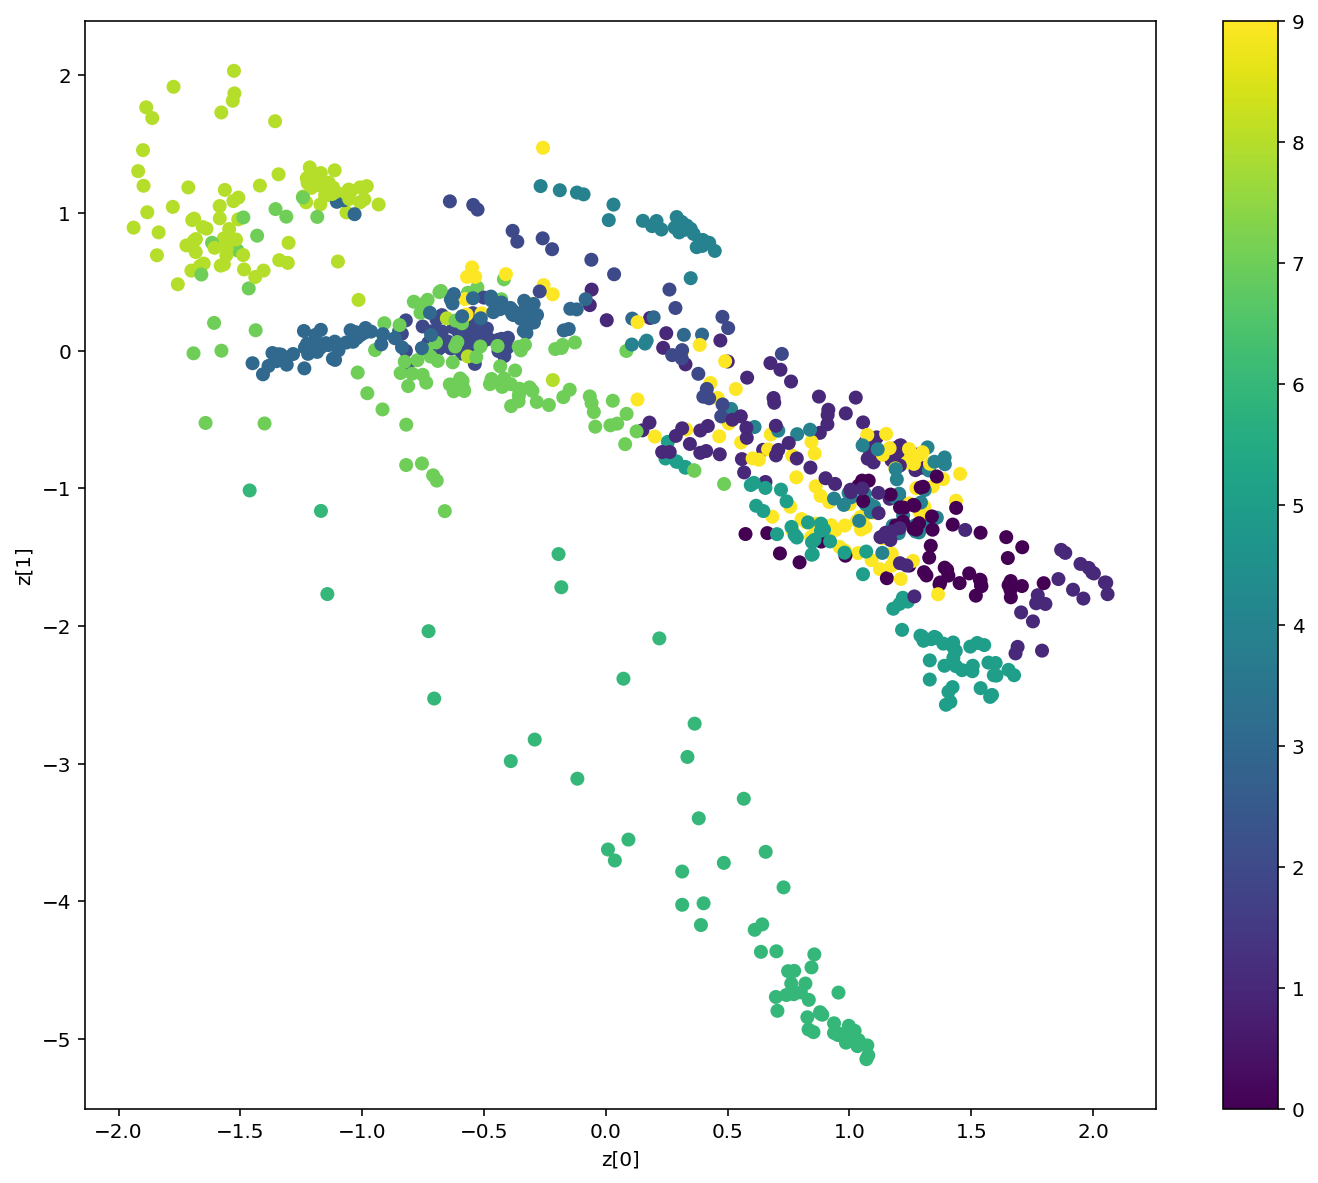

In [361]:
plot_label_clusters(vae, x_train_common_label, labels_common_label)

In [22]:
class VAE_without_kld(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE_without_kld, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder
        self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
        self.reconstruction_loss_tracker = keras.metrics.Mean(
            name="reconstruction_loss"
        )
#         self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

    @property
    def metrics(self):
        return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
#             self.kl_loss_tracker,
        ]

    def train_step(self, data):
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = self.encoder(data)
            reconstruction = self.decoder(z)
            reconstruction_loss = tf.reduce_mean(
                tf.reduce_sum(
                    keras.losses.binary_crossentropy(
                        data,
                        reconstruction
                    ), axis=(1, 2)
                )
            )
#             kl_loss = -0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
#             kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
#             total_loss = reconstruction_loss + kl_loss
        total_loss = reconstruction_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        self.total_loss_tracker.update_state(total_loss)
        self.reconstruction_loss_tracker.update_state(reconstruction_loss)
#         self.kl_loss_tracker.update_state(kl_loss)
        return {
            "loss": self.total_loss_tracker.result(),
            "reconstruction_loss": self.reconstruction_loss_tracker.result(),
#             "kl_loss": self.kl_loss_tracker.result(),
        }

In [23]:
vae = VAE_without_kld(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(np.expand_dims(network_input, -1).astype("float32"), epochs=20, batch_size=32)

Epoch 1/20
59/59 [==============================] - 11s 170ms/step - loss: 3462.8247 - reconstruction_loss: 1689.7816
Epoch 2/20
59/59 [==============================] - 10s 171ms/step - loss: 216.5467 - reconstruction_loss: 210.7018
Epoch 3/20
59/59 [==============================] - 10s 169ms/step - loss: 203.4070 - reconstruction_loss: 202.6425
Epoch 4/20
59/59 [==============================] - 10s 164ms/step - loss: 199.4885 - reconstruction_loss: 198.9701
Epoch 5/20
59/59 [==============================] - 10s 167ms/step - loss: 195.7639 - reconstruction_loss: 195.4258
Epoch 6/20
59/59 [==============================] - 10s 165ms/step - loss: 193.7700 - reconstruction_loss: 193.6118
Epoch 7/20
59/59 [==============================] - 10s 165ms/step - loss: 192.8890 - reconstruction_loss: 192.5405
Epoch 8/20
59/59 [==============================] - 10s 165ms/step - loss: 192.0167 - reconstruction_loss: 191.7632
Epoch 9/20
59/59 [==============================] - 10s 165ms/step - l

In [25]:
pitchnames = sorted(set(item for item in notes))
int_to_note = dict((number, note) for number, note in enumerate(pitchnames))
notes_per_pattern = [[int_to_note[note.argmax()] for note in pattern] for pattern in network_input]
most_common_note_per_pattern = list(map(most_common, notes_per_pattern))

In [26]:
le = LabelEncoder()
labels = le.fit_transform(most_common_note_per_pattern)

x_train = np.expand_dims(network_input, -1).astype("float32")

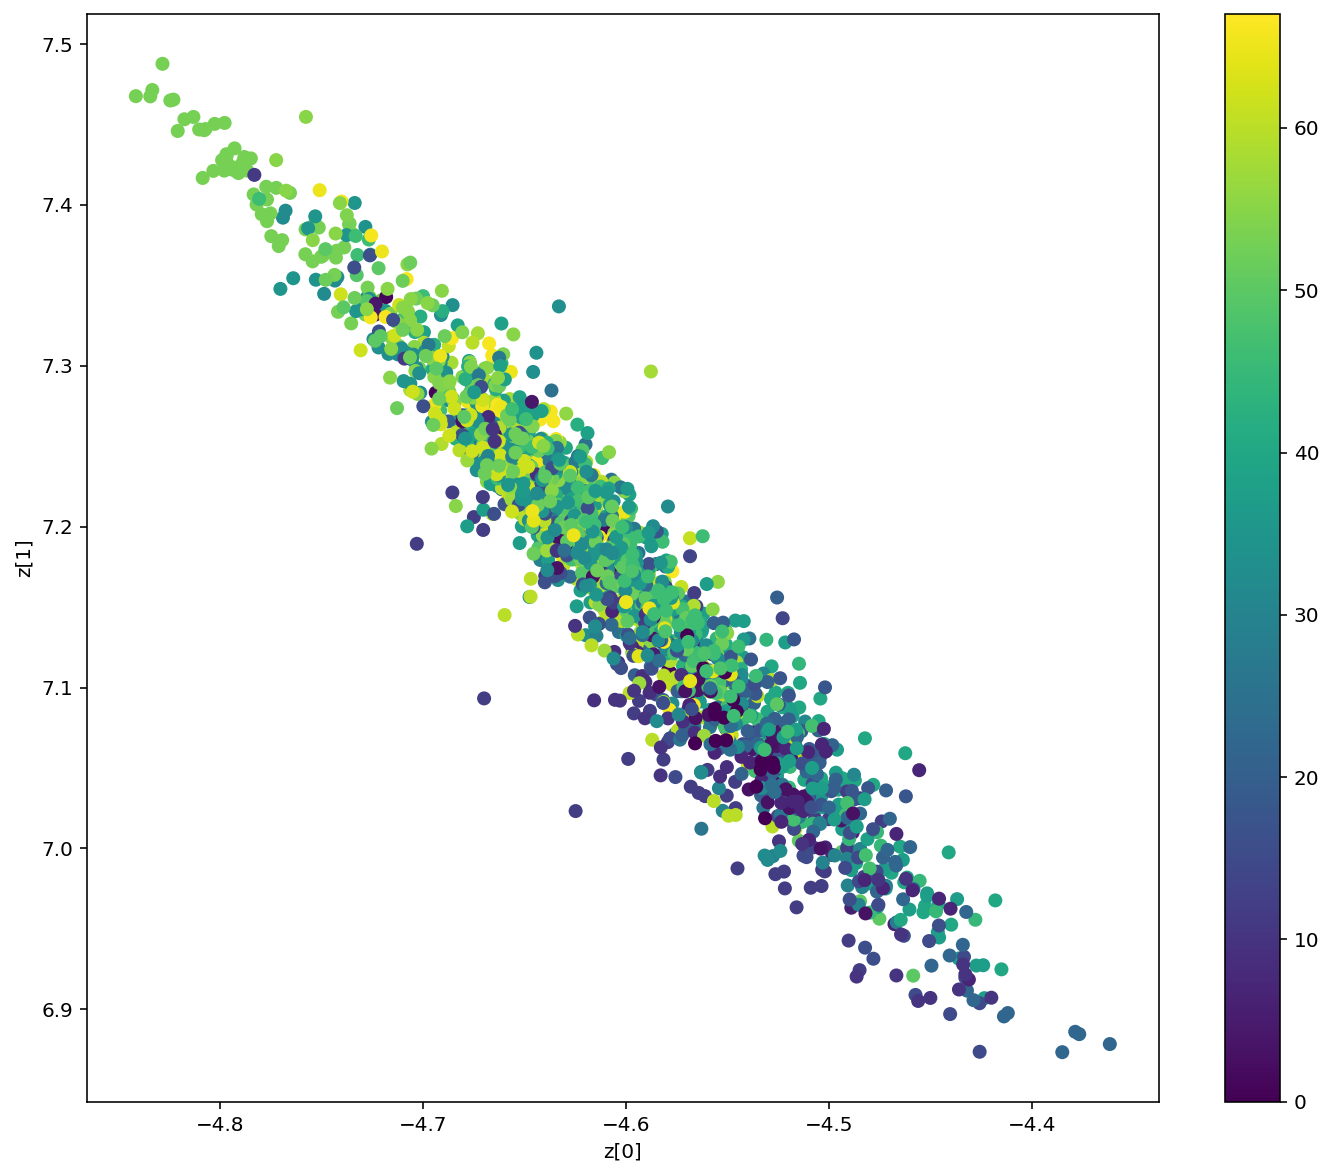

In [28]:
plot_label_clusters(vae, x_train, labels)